# Import des outils / jeu de données

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
np.random.seed(0)
sns.set_theme()

In [3]:
df = pd.read_csv("data/data.csv", sep=",", index_col="ID", parse_dates=True)

In [4]:
df.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
ID,,,,,,,,,,,,,,,,,,,,,
5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,...,7,0,0,0,0,0,0,3,11,1
2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,...,5,0,0,0,0,0,0,3,11,0
4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,...,4,0,0,0,0,0,0,3,11,0
6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,...,6,0,0,0,0,0,0,3,11,0
5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,...,5,0,0,0,0,0,0,3,11,0


## Variables globales

In [5]:
var_numeriques = [
    "Year_Birth",
    "Income",
    "Recency",
    "MntWines",
    "MntFruits",
    "MntMeatProducts",
    "MntFishProducts",
    "MntSweetProducts",
    "MntGoldProds",
    "NumDealsPurchases",
    "NumWebPurchases",
    "NumCatalogPurchases",
    "NumStorePurchases",
    "NumWebVisitsMonth",
]

In [6]:
var_categoriques = [
    "Education",
    "Marital_Status",
    "Kidhome",
    "Teenhome",
    "Complain",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Response",
]

In [7]:
df[var_categoriques] = df[var_categoriques].astype(str).astype("category")

**Tableau.** Tâches effectuées durant le nettoyage des données

| Type                                 | Description                                                                                                         |
|:-------------------------------------|:--------------------------------------------------------------------------------------------------------------------|
| **Données parasites**                | Réponses extravagantes au questionnaire<br>Variables constantes et non-renseignées (`Z_CostContact` et `Z_Revenue`) |
| **Données dupliquées**               | 8% d'individus en double (_182 individus_)                                                                          |
| **Variables pas assez informatives** | Variable catégorique avec plus de 99% d'individus dans une seule classe                                             |
| **Standardisation**                  | Modalités de variable catégoriques en double (_"Seul" / "Célibataire"_)                                             |
| **Valeurs extrêmes**                 | Date de naissance trop anciennes (_1800_)<br>Revenu non crédible (_666 666$_)                                       |
| **Valeurs manquantes**               | Revenu manquant pour 1% des individus => remplacement par la moyenne                                                |

# Nettoyage des données

## Données parasites


### Variables

Dans le jeu de données, 2 colonnes sont non documentées et contiennent des valeurs constantes :
- `Z_CostContact`
- `Z_Revenue`

**Variable `Z_CostContact`**

In [8]:
print(
    f'Il y a {np.sum(df["Z_CostContact"] == 3)} / {len(df)} individus pour lesquelles la variable Z_CostContact vaut 3.'
)

Il y a 2240 / 2240 individus pour lesquelles la variable Z_CostContact vaut 3.


<Axes: >

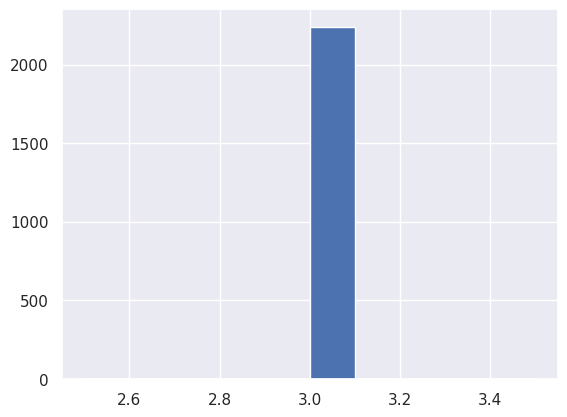

In [9]:
df["Z_CostContact"].hist()

**Variable `Z_Revenue`**

In [10]:
print(
    f'Il y a {np.sum(df["Z_Revenue"] == 11)} / {len(df)} individus pour lesquelles la variable Z_Revenue vaut 11.'
)

Il y a 2240 / 2240 individus pour lesquelles la variable Z_Revenue vaut 11.


<Axes: >

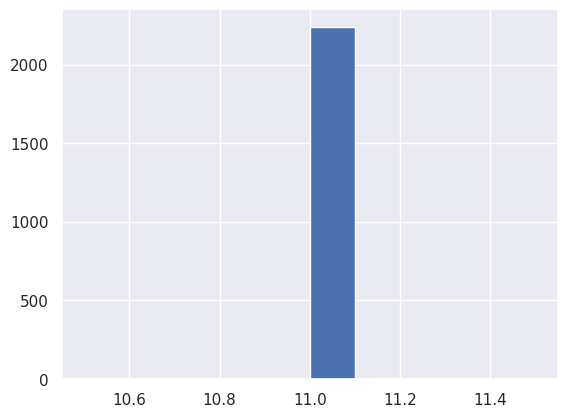

In [11]:
df["Z_Revenue"].hist()

Nous décidons de les supprimer, car elles sont parasites et ne fournissent pas d'information.

In [12]:
df.drop(columns=["Z_CostContact", "Z_Revenue"], inplace=True)

### Valeurs

#### Statut marital

<Axes: xlabel='Count', ylabel='Marital_Status'>

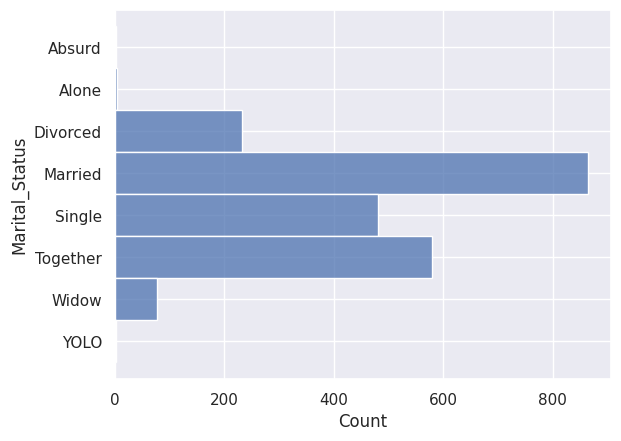

In [13]:
sns.histplot(y=df["Marital_Status"])

Parmi les situations maritales, on observe "absurde" et "YOLO" (You Only Live Once, _on ne vit qu'une fois_).

Comme on ne peut pas déduire ce que veut dire "absurde" dans ce contexte, on se décide de supprimer l'individu.
De même, on suppose que la personne ayant répondu "YOLO", donc ayant répondu de façon humoristique, doit être supprimée du jeu de données.

In [14]:
df.drop(index=df.loc[df["Marital_Status"] == "YOLO"].index, inplace=True)
df.drop(index=df.loc[df["Marital_Status"] == "Absurd"].index, inplace=True)

In [15]:
# On retire les options "YOLO" et "Absurd" de nos variables catégoriques.
df["Marital_Status"] = df["Marital_Status"].cat.remove_categories(["YOLO", "Absurd"])

<Axes: xlabel='Count', ylabel='Marital_Status'>

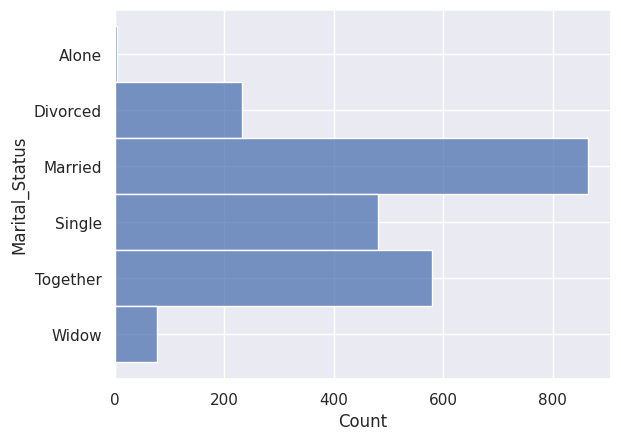

In [16]:
sns.histplot(y=df["Marital_Status"])

## Données dupliquées

### Individus

In [17]:
sum(df.duplicated())

182

Nous observons qu'il y a 182 lignes qui sont dupliquées.

Nous pouvons supposer que les données ont été fusionnées à partir de plusieurs sources, et que ces sources avaient des individus en commun : nous décidons donc de supprimer les doublons.

In [18]:
df.drop_duplicates(inplace=True)

In [19]:
sum(df.duplicated())

0

## Variables pas assez informatives

In [20]:
# todo: dire que la variable "Complain" (si le client s'est plaint ou non), n'apporte pas assez d'information pour être gardée, car il y a moins de 1% des observations qui ont une classe autre que "0", et qu'en plus ce n'est pas central à notre étude

In [21]:
# todo: essayer quand même une visualisation des individus s'étant plaint par rapport à nos variables cibles, au cas où...

<Axes: xlabel='Complain', ylabel='Count'>

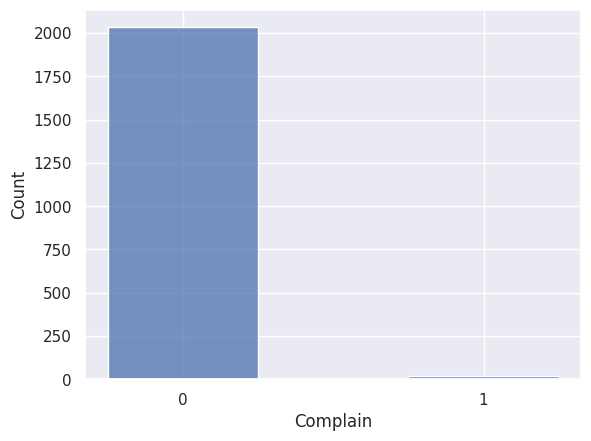

In [22]:
sns.histplot(df["Complain"], shrink=0.5)

In [23]:
print(
    f'Il y a {100 * df["Complain"].astype(int).sum() / len(df["Complain"]):.2f}% des individus qui se sont plaints.'
)

Il y a 0.97% des individus qui se sont plaints.


In [24]:
df.drop(columns=["Complain"], inplace=True)

## Standardisation

### Modalités de variables catégoriques

<Axes: xlabel='Count', ylabel='Marital_Status'>

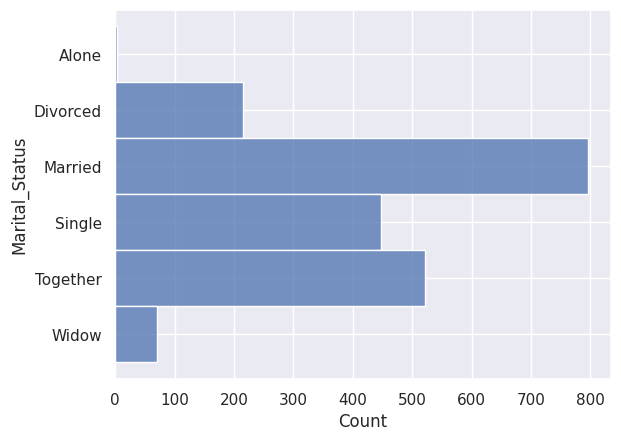

In [25]:
sns.histplot(y=df["Marital_Status"])

Sans plus d'information, "Alone" est une autre formulation de "Single", on décide donc de remplacer "Alone" par "Single".

In [26]:
df["Marital_Status"].replace("Alone", "Single", inplace=True)

<Axes: xlabel='Count', ylabel='Marital_Status'>

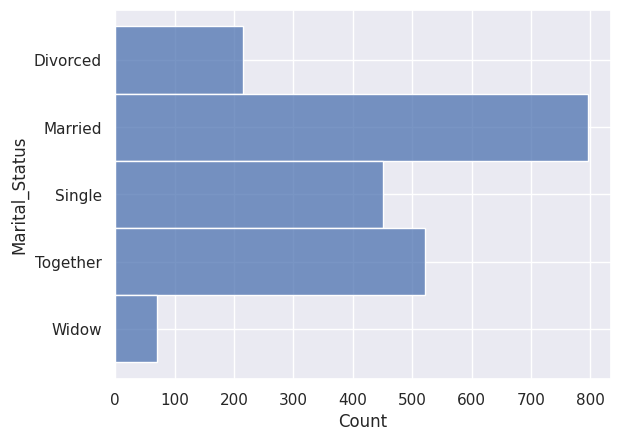

In [27]:
sns.histplot(y=df["Marital_Status"])

## Valeurs extrêmes

### Income

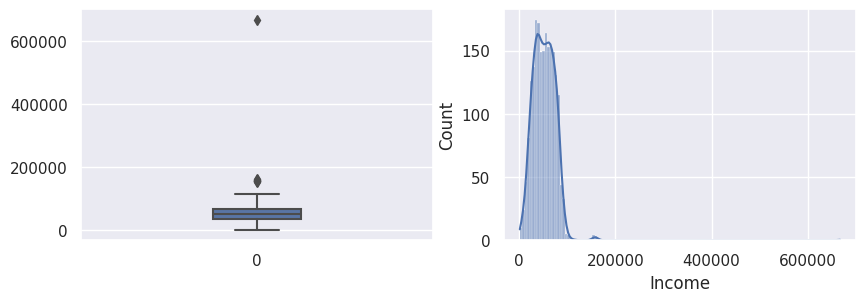

In [28]:
_, ax = plt.subplots(1, 2, figsize=(10, 3))
sns.boxplot(df["Income"], width=0.25, ax=ax[0])
sns.histplot(df["Income"], kde=True, ax=ax[1])
plt.show()

In [29]:
# todo: texte pour commenter

In [30]:
df["Income"][df["Income"] > 200_000]

ID
9432    666666.0
Name: Income, dtype: float64

Pour nous, il s'agit d'une valeur aberrante à supprimer du jeu de données car "666 666" ne semble pas être une valeur réelle (6 fois le nombre 6...).

In [31]:
df.drop(index=df[df["Income"] > 200_000].index, inplace=True)

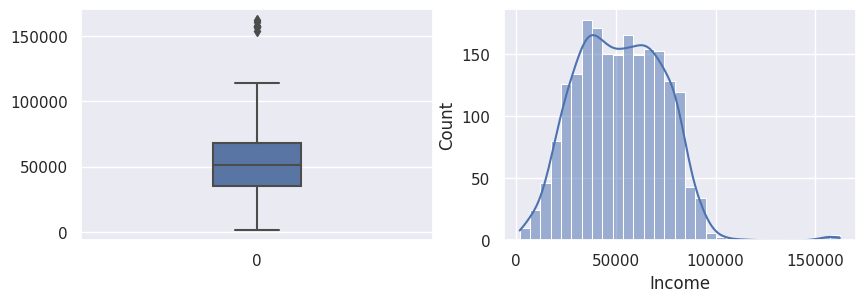

In [32]:
_, ax = plt.subplots(1, 2, figsize=(10, 3))
sns.boxplot(df["Income"], width=0.25, ax=ax[0])
sns.histplot(df["Income"], kde=True, ax=ax[1])
plt.show()

### Year Date

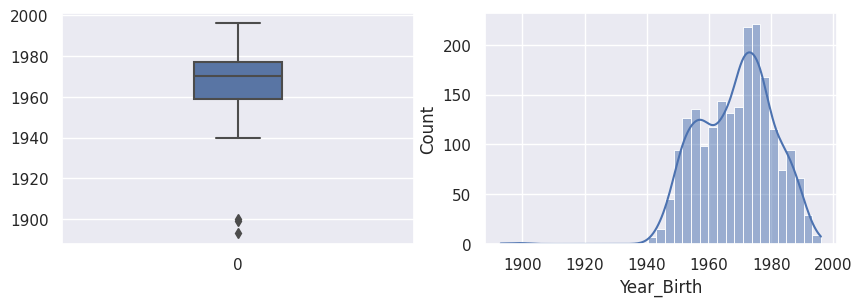

In [33]:
_, ax = plt.subplots(1, 2, figsize=(10, 3))
sns.boxplot(df["Year_Birth"], width=0.25, ax=ax[0])
sns.histplot(df["Year_Birth"], kde=True, ax=ax[1])
plt.show()

In [34]:
df[df["Year_Birth"] < 1920]

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response
ID,,,,,,,,,,,,,,,,,,,,,
7829,1900,2n Cycle,Divorced,36640.0,1,0,2013-09-26,99,15,6,...,2,1,2,5,0,0,0,0,0,0
11004,1893,2n Cycle,Single,60182.0,0,1,2014-05-17,23,8,0,...,1,0,2,4,0,0,0,0,0,0
1150,1899,PhD,Together,83532.0,0,0,2013-09-26,36,755,144,...,4,6,4,1,0,0,1,0,0,0


Comme les personnes les plus âgées au monde ont très rarement plus de 100 ans, et que nous sommes en 2023, on peut sans problème estimer que les trois dates de naissance avant 1920 sont erronées.

Pour les deux années 1893 et 1899, on peut s'imaginer que les personnes ont fait une faute de frappe, et voulaient écrire, respectivement, 1983 et 1989.

In [35]:
df.loc[df["Year_Birth"] == 1893, "Year_Birth"] = 1983
df.loc[df["Year_Birth"] == 1899, "Year_Birth"] = 1989

Pour l'année 1900, il est difficile d'imaginer une faute de frappe, il s'agit peut-être de la valeur par défaut.
On peut tout simplement supprimer la ligne correspondante.

In [36]:
df.drop(index=df.loc[df["Year_Birth"] == 1900, "Year_Birth"].index, inplace=True)

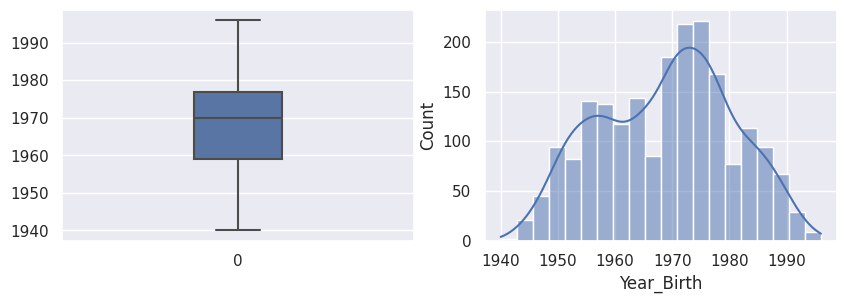

In [37]:
_, ax = plt.subplots(1, 2, figsize=(10, 3))
sns.boxplot(df["Year_Birth"], width=0.25, ax=ax[0])
sns.histplot(df["Year_Birth"], kde=True, ax=ax[1])
plt.show()

## Valeurs manquantes

<Axes: ylabel='ID'>

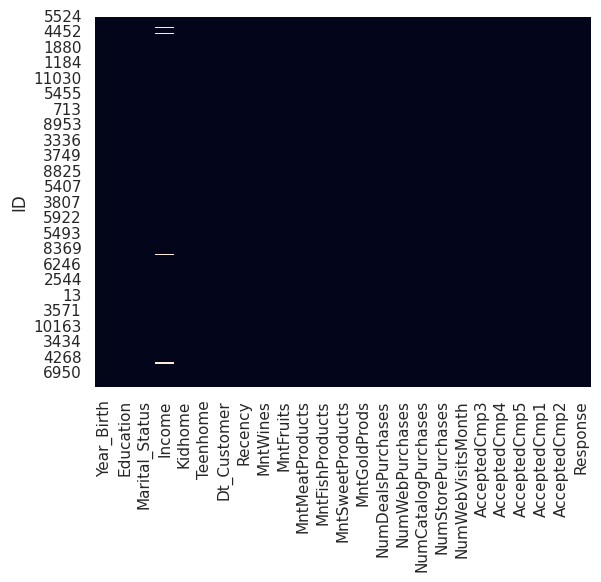

In [38]:
sns.heatmap(
    df.isna(), cbar=False
)  # todo: mettre les graphiques à côté (horizontalement)

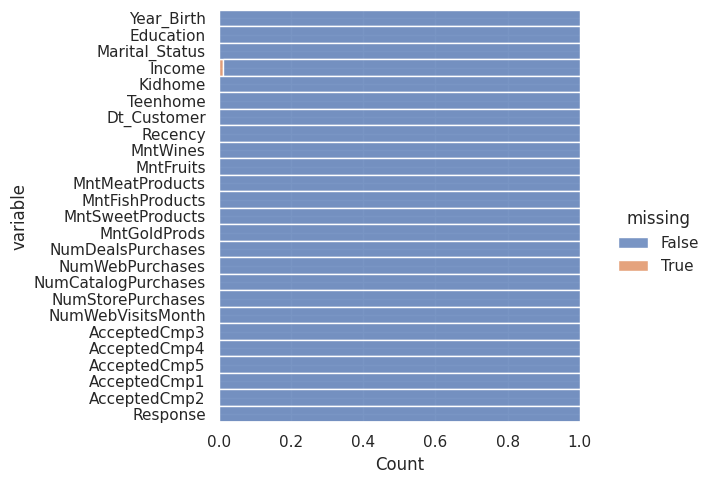

In [39]:
sns.displot(
    data=df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25,
)

<Axes: title={'center': 'Nombre de valeurs manquantes pour chaque variable'}>

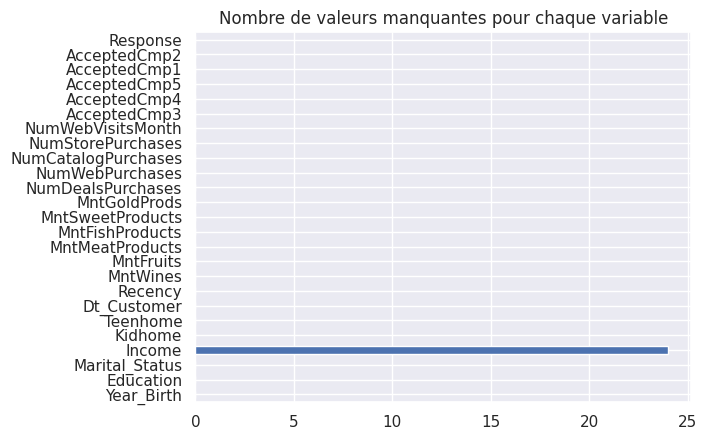

In [40]:
plt.title("Nombre de valeurs manquantes pour chaque variable")
df.isna().sum().plot.barh()

In [41]:
# todo : commenter

In [42]:
# TODO: supprimer valeurs manquantes OU remplacer par la moyenne ?

In [43]:
# todo: expliquer POURQUOI ces données sont manquantes (notre hypothèse du moins), et expliquer notre démarche en conséquence

### Remplacement par la moyenne

In [44]:
df["Income"][df["Income"].isna()]

ID
1994    NaN
5255    NaN
7281    NaN
7244    NaN
8557    NaN
10629   NaN
8996    NaN
9235    NaN
5798    NaN
8268    NaN
1295    NaN
2437    NaN
2863    NaN
10475   NaN
2902    NaN
4345    NaN
3769    NaN
7187    NaN
1612    NaN
5079    NaN
10339   NaN
3117    NaN
5250    NaN
8720    NaN
Name: Income, dtype: float64

In [45]:
df["Income"].fillna(df["Income"].mean(), inplace=True)

In [46]:
# Vérification du bon remplacement des valeurs manquantes
df["Income"].isna().sum()

0

# Sauvegarde du Dataframe

In [47]:
df.to_csv("data/data-cleaned.csv")